In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-05-01'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

sp500

[*********************100%%**********************]  503 of 503 completed


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [2]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-03 A        38.698883   41.240002   41.490002   40.910000   41.320000   
           AAL      33.232189   34.580002   34.770000   33.849998   34.759998   
           AAPL     21.723133   23.795000   23.934999   23.420000   23.549999   
           ABBV     43.775436   61.770000   62.090000   60.720001   60.990002   
           ABT      33.272675   38.549999   38.830002   38.209999   38.799999   
...                       ...         ...         ...         ...         ...   
2024-04-30 XYL     130.699997  130.699997  133.710007  130.580002  132.050003   
           YUM     141.250000  141.250000  142.860001  139.750000  140.000000   
           ZBH     120.279999  120.279999  121.410004  120.260002  120.930000   
           ZBRA    314.559998  314.559998  322.950012  304.209991  320.000000   
           ZTS     159.240005  159.240005  162.130005  158.919998  159.639999   

Price                   volume  
date       ticker               
2016-05-03 A         1334000.0  
           AAL      10674200.0  
           AAPL    227325200.0  
           ABBV      9316600.0  
           ABT      18241600.0  
...                        ...  
2024-04-30 XYL       1397800.0  
           YUM       4087300.0  
           ZBH       1429000.0  
           ZBRA       907700.0  
           ZTS       3647900.0  

[992080 rows x 6 columns]

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=0, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-03 A        38.698883   41.240002   41.490002   40.910000   41.320000   
           AAL      33.232189   34.580002   34.770000   33.849998   34.759998   
           AAPL     21.723133   23.795000   23.934999   23.420000   23.549999   
           ABBV     43.775436   61.770000   62.090000   60.720001   60.990002   
           ABT      33.272675   38.549999   38.830002   38.209999   38.799999   
...                       ...         ...         ...         ...         ...   
2024-04-30 XYL     130.699997  130.699997  133.710007  130.580002  132.050003   
           YUM     141.250000  141.250000  142.860001  139.750000  140.000000   
           ZBH     120.279999  120.279999  121.410004  120.260002  120.930000   
           ZBRA    314.559998  314.559998  322.950012  304.209991  320.000000   
           ZTS     159.240005  159.240005  162.130005  158.919998  159.639999   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-05-03 A         1334000.0         -0.001560        NaN       NaN   
           AAL      10674200.0         -0.000421        NaN       NaN   
           AAPL    227325200.0         -0.002282        NaN       NaN   
           ABBV      9316600.0         -0.042237        NaN       NaN   
           ABT      18241600.0         -0.008994        NaN       NaN   
...                        ...               ...        ...       ...   
2024-04-30 XYL       1397800.0          0.000240  58.416601  4.840933   
           YUM       4087300.0          0.000212  58.971268  4.910309   
           ZBH       1429000.0          0.000034  42.044698  4.767314   
           ZBRA       907700.0          0.001673  64.270565  5.584085   
           ZTS       3647900.0          0.000198  45.063568  4.971909   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-05-03 A            NaN       NaN       NaN       NaN      51.624310  
           AAL          NaN       NaN       NaN       NaN     354.727034  
           AAPL         NaN       NaN       NaN       NaN    4938.215574  
           ABBV         NaN       NaN       NaN       NaN     407.838231  
           ABT          NaN       NaN       NaN       NaN     606.946820  
...                     ...       ...       ...       ...            ...  
2024-04-30 XYL     4.867190  4.893447  0.499441 -0.174045     182.692456  
           YUM     4.940215  4.970122  0.318507 -0.126081     577.331125  
           ZBH     4.824458  4.881602 -0.606773 -0.116166     171.880118  
           ZBRA    5.668465  5.752845  0.435830  0.163059     285.526110  
           ZTS     5.058219  5.144529  1.243102  0.164096     580.891616  

[992080 rows x 14 columns]

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-06-30 AMCR         0.000574    7.963774         -0.044452  32.433395   
           AMD        137.761163    5.140000          0.001119  61.255503   
           AME         66.286129   43.884991         -0.000416  46.868304   
           AMGN       359.507104  120.918808         -0.018725  49.158004   
           AMP        112.060790   75.306686         -0.010524  39.636005   
...                          ...         ...               ...        ...   
2024-04-30 XYL        141.201398  130.699997          0.000240  58.416601   
           YUM        281.317689  141.250000          0.000212  58.971268   
           ZBH        138.737653  120.279999          0.000034  42.044698   
           ZBRA       107.609234  314.559998          0.001673  64.270565   
           ZTS        662.469321  159.240005          0.000198  45.063568   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-06-30 AMCR    2.162175  2.203412  2.244648 -1.209928 -0.236008  
           AMD     1.622225  1.750861  1.879498 -1.112002 -0.442376  
           AME     3.758668  3.815853  3.873037 -1.093727 -0.382646  
           AMGN    4.751533  4.805776  4.860019 -0.991784  0.098795  
           AMP     4.294568  4.403750  4.512931 -0.913008  0.219963  
...                     ...       ...       ...       ...       ...  
2024-04-30 XYL     4.840933  4.867190  4.893447  0.499441 -0.174045  
           YUM     4.910309  4.940215  4.970122  0.318507 -0.126081  
           ZBH     4.767314  4.824458  4.881602 -0.606773 -0.116166  
           ZBRA    5.584085  5.668465  5.752845  0.435830  0.163059  
           ZTS     4.971909  5.058219  5.144529  1.243102  0.164096  

[44470 rows x 9 columns]

In [5]:
data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean()

ticker,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,...,UBER,CARR,OTIS,AMAT,CEG,GEHC,KVUE,VLTO,GEV,SOLV
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,67.847459,5193.370415,122.731404,578.418371,144.075870,404.046242,9553.314113,250.309539,137.046805,282.128452,...,949.648908,207.276226,170.727989,881.768558,178.828184,215.653172,NaN,NaN,NaN,NaN
2024-01-31,69.129684,5407.999801,123.699372,581.097754,145.942281,406.845691,9495.224937,254.704659,143.042932,285.532358,...,957.102268,206.751825,171.522809,885.886468,178.805674,214.125370,NaN,NaN,NaN,NaN
2024-02-29,70.765459,5566.733735,125.193830,591.647993,146.633270,410.351095,9528.529384,263.979396,145.344150,287.641287,...,972.297261,208.813306,171.813282,899.673245,185.258106,226.263097,NaN,NaN,NaN,NaN


In [6]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-05-31 AMD      11.190000          0.000566  45.177933  2.382118   
           AMGN    126.701012         -0.014325  39.732636  4.827340   
           AMT     111.686913         -0.011078  66.001935  4.680210   
           AMZN     49.730999          0.000153  71.677950  3.855167   
           AVGO    190.127380         -0.022637  61.648389  5.180430   
...                       ...               ...        ...       ...   
2024-04-30 VZ       39.490002          0.000030  47.152729  3.676888   
           WFC      59.320000          0.000058  59.907337  4.029370   
           WMT      59.349998          0.000104  48.755055  4.095619   
           XOM     117.317093          0.000085  56.018702  4.768321   
           ZTS     159.240005          0.000198  45.063568  4.971909   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-05-31 AMD     2.480309  2.578499 -0.995881 -0.376623  
           AMGN    4.867713  4.908087 -1.578500  0.011416  
           AMT     4.705886  4.731562 -0.882788  0.339855  
           AMZN    3.894815  3.934463 -1.362733  0.197874  
           AVGO    5.230706  5.280982 -0.887893  0.842135  
...                     ...       ...       ...       ...  
2024-04-30 VZ      3.718506  3.760124  0.127688 -0.585880  
           WFC     4.083863  4.138357  0.142778 -0.610345  
           WMT     4.107957  4.120295  0.588578 -0.518415  
           XOM     4.788428  4.808535  0.788546 -0.213949  
           ZTS     5.058219  5.144529  1.243102  0.164096  

[12516 rows x 8 columns]

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-05-31 AMD      13.730000          0.000151  70.721591  2.484821   
           AMGN    150.875443         -0.012168  57.377183  4.933561   
           AMT     120.186203         -0.006631  50.976053  4.775463   
           AMZN     81.481003          0.000029  61.967517  4.372476   
           AVGO    206.110870         -0.013646  59.901270  5.235245   
...                       ...               ...        ...       ...   
2024-04-30 VZ       39.490002          0.000030  47.152729  3.676888   
           WFC      59.320000          0.000058  59.907337  4.029370   
           WMT      59.349998          0.000104  48.755055  4.095619   
           XOM     117.317093          0.000085  56.018702  4.768321   
           ZTS     159.240005          0.000198  45.063568  4.971909   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-05-31 AMD     2.607078  2.729334 -1.075564 -0.314201   0.261948   
           AMGN    4.989607  5.045653 -0.671468  0.019046   0.037404   
           AMT     4.790683  4.805904 -0.844744  0.259765   0.014740   
           AMZN    4.392420  4.412364 -0.953448  0.201473   0.040539   
           AVGO    5.288347  5.341449 -0.778835  0.555606   0.098727   
...                     ...       ...       ...       ...        ...   
2024-04-30 VZ      3.718506  3.760124  0.127688 -0.585880  -0.043625   
           WFC     4.083863  4.138357  0.142778 -0.610345   0.023464   
           WMT     4.107957  4.120295  0.588578 -0.518415  -0.013628   
           XOM     4.788428  4.808535  0.788546 -0.213949   0.017464   
           ZTS     5.058219  5.144529  1.243102  0.164096  -0.056238   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-05-31 AMD      0.168832   0.042739   0.039379   0.006089    0.017193  
           AMGN     0.030410  -0.005038   0.006272   0.003605    0.014658  
           AMT     -0.021707  -0.000554  -0.004849  -0.005814    0.006131  
           AMZN     0.061104   0.025184   0.055764   0.058060    0.042003  
           AVGO     0.034253   0.012428  -0.012676   0.002808    0.006749  
...                      ...        ...        ...        ...         ...  
2024-04-30 VZ       0.001367  -0.017792   0.025277   0.022612    0.007403  
           WFC      0.033005   0.059831   0.071741   0.030970    0.036638  
           WMT      0.008005   0.026343   0.015605   0.013245    0.015065  
           XOM      0.063745   0.051039   0.021784   0.013920    0.002885  
           ZTS     -0.101802  -0.052622   0.003218  -0.016990   -0.007148  

[10368 rows x 14 columns]

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AMD     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.261948
           AMGN    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.037404
           AMT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.014740
           AMZN    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.040539
           AVGO    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.098727
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132
           ZTS     0.0283 -0.0116  0.0419  0.0148  0.0118  -0.142715

[10225 rows x 6 columns]

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data
# observations

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AMD     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.261948
           AMGN    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.037404
           AMT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.014740
           AMZN    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.040539
           AVGO    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.098727
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10185 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-05-31 AMD          NaN       NaN       NaN       NaN       NaN
           AMGN         NaN       NaN       NaN       NaN       NaN
           AMT          NaN       NaN       NaN       NaN       NaN
           AMZN         NaN       NaN       NaN       NaN       NaN
           AVGO         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VRTX    0.268801  0.654605 -0.656893  0.402016  0.781699
           VZ      0.506034 -1.155973  0.600674  0.007151 -0.205276
           WFC     1.173197  0.311765  1.186081 -0.546275 -0.753658
           WMT     0.520277  0.219254 -0.675270  0.724903  0.581208
           XOM     0.808571 -0.071684  0.667508  0.882268  0.351962

[10185 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10157 entries, (Timestamp('2018-05-31 00:00:00'), 'AMD') to (Timestamp('2024-04-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10157 non-null  float64
 1   rsi               10157 non-null  float64
 2   bb_low            10157 non-null  float64
 3   bb_mid            10157 non-null  float64
 4   bb_high           10157 non-null  float64
 5   atr               10157 non-null  float64
 6   macd              10157 non-null  float64
 7   return_1m         10157 non-null  float64
 8   return_2m         10157 non-null  float64
 9   return_3m         10157 non-null  float64
 10  return_6m         10157 non-null  float64
 11  return_9m         10157 non-null  float64
 12  return_12m        10157 non-null  float64
 13  Mkt-RF            10157 non-null  float64
 14  SMB               10157 non-null  float64
 15  HML        

In [12]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-05-31 AMD             0.000151  70.721591  2.484821  2.607078  2.729334   
           AMGN           -0.012168  57.377183  4.933561  4.989607  5.045653   
           AMT            -0.006631  50.976053  4.775463  4.790683  4.805904   
           AMZN            0.000029  61.967517  4.372476  4.392420  4.412364   
           AVGO           -0.013646  59.901270  5.235245  5.288347  5.341449   
...                             ...        ...       ...       ...       ...   
2024-04-30 VRTX            0.000052  39.263843  5.968375  5.991985  6.015594   
           VZ              0.000030  47.152729  3.676888  3.718506  3.760124   
           WFC             0.000058  59.907337  4.029370  4.083863  4.138357   
           WMT             0.000104  48.755055  4.095619  4.107957  4.120295   
           XOM             0.000085  56.018702  4.768321  4.788428  4.808535   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-05-31 AMD    -1.075564 -0.314201   0.261948   0.168832   0.042739   
           AMGN   -0.671468  0.019046   0.037404   0.030410  -0.005038   
           AMT    -0.844744  0.259765   0.014740  -0.021707  -0.000554   
           AMZN   -0.953448  0.201473   0.040539   0.061104   0.025184   
           AVGO   -0.778835  0.555606   0.098727   0.034253   0.012428   
...                     ...       ...        ...        ...        ...   
2024-04-30 VRTX    0.639787  0.207522  -0.060286  -0.033761  -0.032232   
           VZ      0.127688 -0.585880  -0.043625   0.001367  -0.017792   
           WFC     0.142778 -0.610345   0.023464   0.033005   0.059831   
           WMT     0.588578 -0.518415  -0.013628   0.008005   0.026343   
           XOM     0.788546 -0.213949   0.017464   0.063745   0.051039   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-05-31 AMD      0.039379   0.006089    0.017193  1.967450 -1.149488   
           AMGN     0.006272   0.003605    0.014658  0.744363  0.140957   
           AMT     -0.004849  -0.005814    0.006131  0.611536 -0.117348   
           AMZN     0.055764   0.058060    0.042003  1.304593 -0.573355   
           AVGO    -0.012676   0.002808    0.006749  1.057758  0.328382   
...                      ...        ...         ...       ...       ...   
2024-04-30 VRTX     0.013655   0.012154    0.011923  0.518301  0.063723   
           VZ       0.025277   0.022612    0.007403  0.471201 -0.417800   
           WFC      0.071741   0.030970    0.036638  1.073262 -0.093282   
           WMT      0.015605   0.013245    0.015065  0.605785 -0.404728   
           XOM      0.021784   0.013920    0.002885  1.089635  0.189620   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-05-31 AMD    -0.373080 -0.891095  0.025648        0  
           AMGN   -0.547266  0.515339  1.470774        3  
           AMT    -0.408995  0.399552  0.456338        2  
           AMZN   -0.478582 -0.465334 -0.114501        0  
           AVGO   -0.419689  0.429352  0.264761        3  
...                     ...       ...       ...      ...  
2024-04-30 VRTX   -0.900771  0.050899  0.857427        1  
           VZ      0.187598  0.240247  0.286740        1  
           WFC     1.560105 -0.765962 -0.813227        0  
           WMT    -0.362731  0.251171  0.693314        3  
           XOM     0.795498 -0.466737  0.496622        3  

[10157 rows x 19 columns]

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [14]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [15]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-06-01': ['AMGN',
  'AVGO',
  'BA',
  'BSX',
  'COP',
  'COST',
  'CRM',
  'EA',
  'F',
  'GOOG',
  'GOOGL',
  'HD',
  'INTC',
  'ISRG',
  'MA',
  'MDT',
  'MPC',
  'MRK',
  'MSFT',
  'MU',
  'NEE',
  'NKE',
  'NVDA',
  'NXPI',
  'ORLY',
  'PFE',
  'PYPL',
  'QCOM',
  'TXN',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'V',
  'WYNN',
  'XOM'],
 '2018-07-01': ['AMT',
  'BDX',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'EQIX',
  'KHC',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX',
  'VZ'],
 '2018-08-01': ['AMZN',
  'AZO',
  'BA',
  'BAC',
  'BIIB',
  'BRK-B',
  'BSX',
  'CAT',
  'CHTR',
  'CI',
  'COP',
  'CTSH',
  'CVX',
  'DAL',
  'DD',
  'DE',
  'DG',
  'DHR',
  'DLTR',
  'EQIX',
  'FDX',
  'GD',
  'GE',
  'GOOG',
  'GOOGL',
  'GS',
  'HD',
  'HUM',
  'IBM',
  'ISRG',
  'KR',
  'LOW',
  'LRCX',
  'MET',
  'MGM',
  'MO',
  'MS',
  'MSFT',
  'NEE',
  'NKE',
  'ORCL',
  'OXY',
  'PNC',
  'SLB',
  'T',
  'TMUS',
  'UNH',
  'V',
  

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [17]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

# new_df
test_df = pd.DataFrame(new_df)
# test_df

# Melt the DataFrame



[*********************100%%**********************]  152 of 152 completed


In [18]:
test_df

Price        Adj Close                                                   \
Ticker             AMD        AMGN         AMT        AMZN         AVGO   
Date                                                                      
2017-05-31   11.190000  126.701019  111.686913   49.730999   190.127411   
2017-06-01   10.930000  127.517197  112.231750   49.797501   186.245132   
2017-06-02   10.900000  129.892151  112.793655   50.336498   202.075851   
2017-06-05   11.240000  130.765503  112.044441   50.567001   200.233978   
2017-06-06   12.030000  130.202301  112.121086   50.150002   201.543930   
...                ...         ...         ...         ...          ...   
2024-04-23  152.270004  273.540009  174.179993  179.539993  1249.189941   
2024-04-24  151.740005  273.010010  173.350006  176.589996  1256.819946   
2024-04-25  153.759995  269.380005  172.899994  173.669998  1294.420044   
2024-04-26  157.399994  269.980011  171.690002  179.619995  1344.069946   
2024-04-29  160.199997  276.380005  174.990005  180.960007  1338.619995   

Price                                                                   ...  \
Ticker             AXP          AZO          BA        BAC         BDX  ...   
Date                                                                    ...   
2017-05-31   69.631706   605.919983  176.799454  19.167330  167.744415  ...   
2017-06-01   70.844406   623.979980  176.507339  19.355495  170.935654  ...   
2017-06-02   71.034454   621.700012  179.249374  19.201542  171.139496  ...   
2017-06-05   71.468895   617.070007  178.043243  19.167330  171.148376  ...   
2017-06-06   71.360298   603.880005  175.970261  19.013376  170.111267  ...   
...                ...          ...         ...        ...         ...  ...   
2024-04-23  238.960007  2961.040039  169.179993  38.369999  234.360001  ...   
2024-04-24  239.119995  2988.510010  164.330002  38.320000  233.830002  ...   
2024-04-25  237.100006  2945.250000  166.809998  37.910000  230.479996  ...   
2024-04-26  235.639999  2945.979980  167.220001  37.830002  231.550003  ...   
2024-04-29  238.919998  2998.780029  173.490005  37.549999  233.440002  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-05-31   9866000  4655900  2813600  22811100   4355600   5531700   
2017-06-01   8911900  3541400  3356300  14219400   3692500   3520300   
2017-06-02   8570200  2788900  2837100  18552800   3940900   3191100   
2017-06-05  14510500  3897100  2030000   8538200   2824000   4286100   
2017-06-06   7030300  2579800  1250600  11610500   6663800   3626200   
...              ...      ...      ...       ...       ...       ...   
2024-04-23   6438000  1969300  1070300  25972800   7297000   7710600   
2024-04-24   8807200  2350800   806500  15946600  10269700   7400400   
2024-04-25   8064600  3299400   787600  16837700   7865500   8613200   
2024-04-26   6840600  2065200   682500  18246200   6592000  13869100   
2024-04-29   4128600  2081800   604500  19438600   6688800   8998600   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-05-31  30519700  24605100  1697100  13572300  
2017-06-01  21001800  24459300  4059300   9884100  
2017-06-02  19477300  23989500  2293600  21687300  
2017-06-05  13663800  30437100  1423700  11527100  
2017-06-06  14887500  34577700  1892400  12208600  
...              ...       ...      ...       ...  
2024-04-23  21731200  17963900  1231800  13929800  
2024-04-24  19731600  18529100  1256700  12101200  
2024-04-25  24002500  19263000   948900  16041000  
2024-04-26  18785900  11045200  1420000  27289500  
2024-04-29  15338400   9785100  1588300  17309900  

[1740 rows x 912 columns]

In [19]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Ticker', 'Date']).unstack().stack()

        temp_df.index.names = ['ticker','date']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        temp_df = temp_df.groupby(level=1)['weighted_return'].sum().to_frame('Strategy Return')
        print(temp_df)

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

            Strategy Return
date                       
2018-06-01         0.013414
2018-06-04         0.000180
2018-06-05        -0.003836
2018-06-06         0.006323
2018-06-07        -0.001532
2018-06-08         0.003604
2018-06-11         0.001367
2018-06-12        -0.003498
2018-06-13        -0.007249
2018-06-14         0.000465
2018-06-15        -0.008165
2018-06-18         0.003261
2018-06-19        -0.008222
2018-06-20         0.004973
2018-06-21        -0.009980
2018-06-22         0.002269
2018-06-25        -0.023888
2018-06-26         0.005072
2018-06-27        -0.010403
2018-06-28         0.006398
2018-06-29         0.006374
            Strategy Return
date                       
2018-07-02         0.002611
2018-07-03        -0.005860
2018-07-05         0.009861
2018-07-06         0.009522
2018-07-09         0.001024
2018-07-10         0.003691
2018-07-11         0.000187
2018-07-12         0.001073
2018-07-13         0.000532
2018-07-16        -0.002817
2018-07-17        -0

,Strategy Return
date,
2018-06-01,0.013414
2018-06-04,0.000180
2018-06-05,-0.003836
2018-06-06,0.006323
2018-06-07,-0.001532
...,...
2024-04-23,0.020022
2024-04-24,-0.003273
2024-04-25,0.009260


In [20]:
Spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

Spy_ret = np.log(Spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(Spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-06-01,0.013414,0.009770
2018-06-04,0.000180,0.004740
2018-06-05,-0.003836,0.000728
2018-06-06,0.006323,0.008326
2018-06-07,-0.001532,-0.000108
...,...,...
2024-04-23,0.020022,0.011797
2024-04-24,-0.003273,-0.000475
2024-04-25,0.009260,-0.003806
2024-04-26,0.009208,0.009429


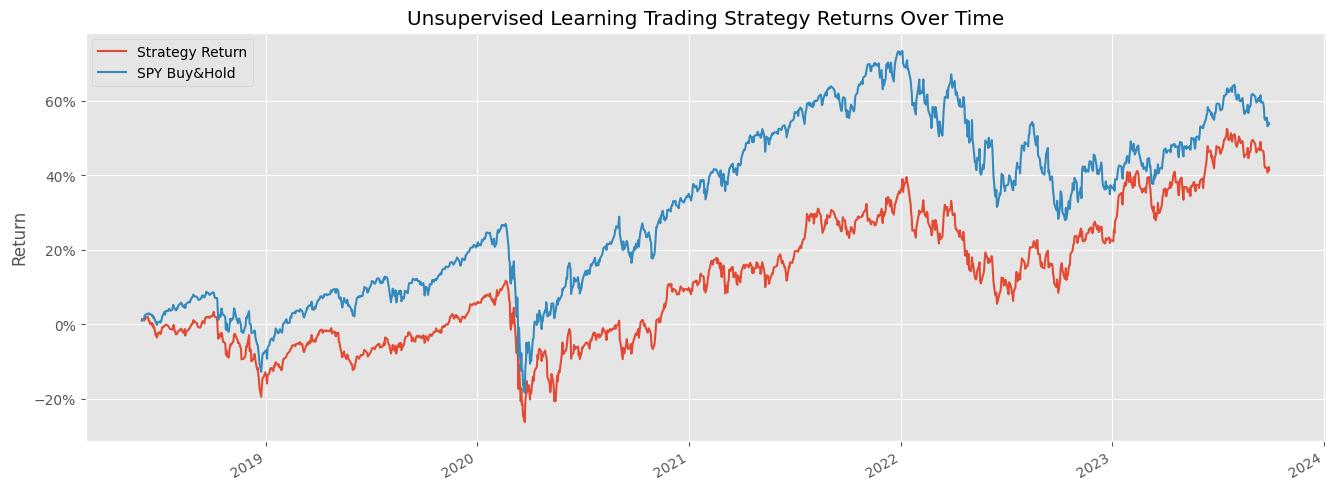

In [21]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
